In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [3]:
csv1 = "movie_data/movies.csv"
csv2 = "movie_data/ratings.csv"
csv3 = "movie_data/genome-scores.csv"
csv4 = "movie_data/genome-tags.csv"
csv5 = "movie_data/links.csv"
csv6 = "movie_data/tags.csv"

In [4]:
movies_df = pd.read_csv(csv1)
ratings_df = pd.read_csv(csv2)
genome_scores_df = pd.read_csv(csv3)
genome_tags_df = pd.read_csv(csv4)
links_df = pd.read_csv(csv5)
tags_df = pd.read_csv(csv6)

In [5]:
print(f'{len(movies_df)} movies')
print(f'{len(ratings_df)} ratings')

62423 movies
25000095 ratings


In [6]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [7]:
# # Number of ratings for each userId
# ratings_df.groupby(ratings_df['userId'])['rating'].count()

In [8]:
genome_scores_df.head()

,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


In [9]:
relevant_genome_scores_df = genome_scores_df.loc[genome_scores_df['relevance'] > .85]

In [10]:
genome_tags_df.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [11]:
links_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [12]:
tags_df.head()

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


In [13]:
new_df = ratings_df.merge(movies_df, how="inner")
new_df = new_df.drop(columns=['title', 'genres', 'timestamp'])
new_df.head()

,userId,movieId,rating
0,1,296,5.0
1,3,296,5.0
2,4,296,4.0
3,5,296,4.0
4,7,296,4.0


In [14]:
new_df["rating"] = np.where(new_df["rating"] >= 3.5, 1, 0)

In [15]:
new_df

,userId,movieId,rating
0,1,296,1
1,3,296,1
2,4,296,1
3,5,296,1
4,7,296,1
...,...,...,...
25000090,162358,200192,0
25000091,162358,200194,0
25000092,162386,139970,1
25000093,162386,200726,1


In [16]:
X = new_df.drop('rating', axis=1)
y = new_df['rating']

In [17]:
from sklearn import preprocessing
from sklearn import utils

#convert y values to categorical values
lab = preprocessing.LabelEncoder()
y_transformed = lab.fit_transform(y)

#view transformed values
print(y_transformed)
X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, random_state=1)

[1 1 1 ... 1 1 1]


In [18]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
print(f"Training Data Score: {classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test, y_test)}")

Training Data Score: 0.6251565127406717
Testing Data Score: 0.625341598688261


In [19]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [20]:
movie_ratings = movies_df.merge(ratings_df, how="inner")
movie_ratings

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2,3.5,1141415820
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3,4.0,1439472215
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4,3.0,1573944252
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,858625949
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8,4.0,890492517
...,...,...,...,...,...,...
25000090,209157,We (2018),Drama,119571,1.5,1574280748
25000091,209159,Window of the Soul (2001),Documentary,115835,3.0,1574280985
25000092,209163,Bad Poems (2018),Comedy|Drama,6964,4.5,1574284913
25000093,209169,A Girl Thing (2001),(no genres listed),119571,3.0,1574291826


In [ ]:
# movie_ratings.groupby('movieId').mean()

In [22]:
movie_ratings['year'] = movie_ratings.title.str.extract('\((.*)\)')[0]

movie_ratings['release_year'] = movie_ratings['year'].str.split('(').str[-1]
movie_ratings = movie_ratings.drop(columns = ['year'])

In [23]:
movie_ratings.head()

,movieId,title,genres,userId,rating,timestamp,release_year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2,3.5,1141415820,1995
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3,4.0,1439472215,1995
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4,3.0,1573944252,1995
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,858625949,1995
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8,4.0,890492517,1995


In [37]:
genres = ['Comedy','Adventure','Animation','Children','Fantasy','Romance','Drama',
          'Documentary','Action','Horror','Mystery','Sci-Fi','Western','Crime','Thriller',
          'Film-Noir','Musical','War']
print(len(genres))

18


In [25]:
def genre_ratings(genre):
    df = movies_df[movies_df['genres'].str.contains(genre, regex=False)]
    genre_df = ratings_df.merge(df, how="inner")
    return genre_df

In [26]:
genre_averages = {
    'Genre': [],
    'Average Rating': []
}
for genre in genres:
    avg_rating = genre_ratings(genre)['rating'].mean()
    genre_averages['Genre'].append(genre)
    genre_averages['Average Rating'].append(avg_rating)

genre_avg_df = pd.DataFrame(genre_averages).sort_values('Average Rating', ascending=False)

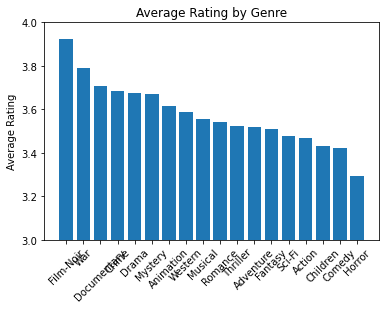

In [27]:
plt.bar(genre_avg_df['Genre'],genre_avg_df['Average Rating'])
plt.ylim(3, 4)
plt.title('Average Rating by Genre')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.savefig('avg_rating_by_genre.png')

In [31]:
def ratings_by_year(genre, year):
    df = movie_ratings[movie_ratings['genres'].str.contains(genre, regex=False)]
    year_df = df.loc[movie_ratings['release_year'] == year]
    avg_rating = year_df.groupby('release_year')['rating'].mean()
    return avg_rating[0]

In [32]:
ratings_by_year('Action','1995')

3.2622840986600363

In [33]:
ratings_dict = {
    'Year': [],
    'Average Rating': []
}

years = ['1993','1994','1995','1996','1997','1998','1999','2000','2001','2002','2003','2004','2005','2006',
         '2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018']

for year in years:
    avg = ratings_by_year('Action',year)
    ratings_dict['Average Rating'].append(avg)
    ratings_dict['Year'].append(year)
    
ratings_dict_df = pd.DataFrame(ratings_dict)

In [39]:
ratings_dict_df.head()

,Year,Average Rating
0,1993,3.321632
1,1994,3.343275
2,1995,3.262284
3,1996,3.255737
4,1997,3.231744


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

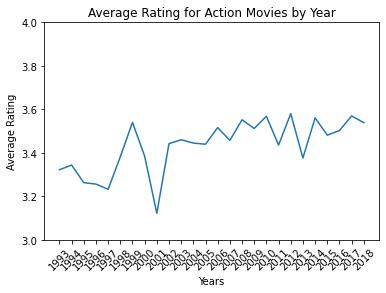

In [36]:
plt.plot(ratings_dict_df['Year'],ratings_dict_df['Average Rating'])
plt.ylim(3, 4)
plt.title('Average Rating for Action Movies by Year')
plt.ylabel('Average Rating')
plt.xlabel('Years')
labels = ratings_dict_df['Year']
plt.xticks(ratings_dict_df['Year'],rotation=45)

In [41]:
def plot_genre_by_year(genre):
    ratings_dict = {
        'Year': [],
        'Average Rating': []
    }

    years = ['2014','2015','2016','2017','2018']

    for year in years:
        avg = ratings_by_year(genre,year)
        ratings_dict['Average Rating'].append(avg)
        ratings_dict['Year'].append(year)

    ratings_dict_df = pd.DataFrame(ratings_dict)

    ## Plot
    plt.plot(ratings_dict_df['Year'],ratings_dict_df['Average Rating'])
    plt.ylim(3, 4)
    plt.title(f'Average Rating for {genre} Movies by Year')
    plt.ylabel('Average Rating')
    plt.xlabel('Years')
    plt.xticks(rotation=45)
    plt.savefig(f'avg_rating_by_year_{genre}.png')
    plt.show()

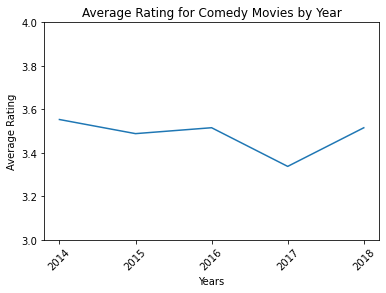

In [42]:
plot_genre_by_year('Comedy')